#Advanced segmentation with *Encoder* pre-trained.

<br>
<img width=400px src='https://github.com/anantgupta129/Image-Segmentation-Using-Pets-Dataset/raw/main/img/dataset.png'>
<br>

---

**This project will consist of the following:

- Using the Oxford Pets dataset, so that the training input images are preprocessed using the function corresponding to the pre-trained model, in this case ResNet50.

- We generate an Encoder-Decoder architecture, where the encoder part uses a truncated pre-trained convolutional network *(Resnet, MobileNet v2, etc)*. We check if the training performance improves compared to the model without pre-training.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-270ynu1t
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-270ynu1t
  Resolved https://github.com/tensorflow/examples.git to commit 37df0b9a2f7240831642cea4380e4f7ec33bee83
  Preparing metadata (setup.py) ... done


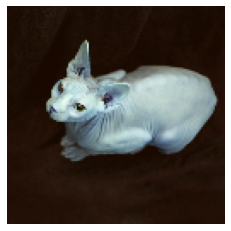

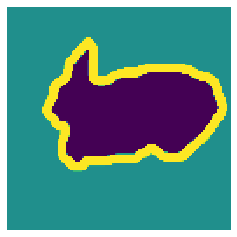

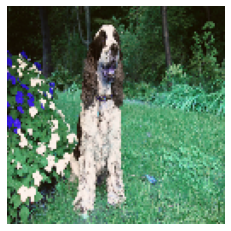

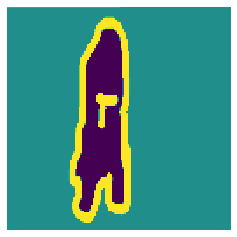

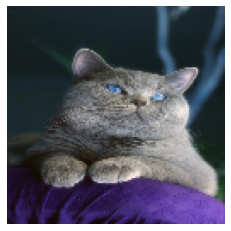

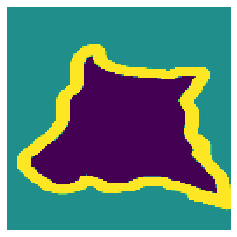

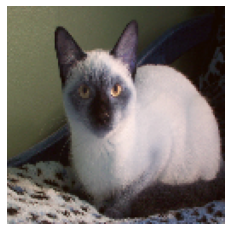

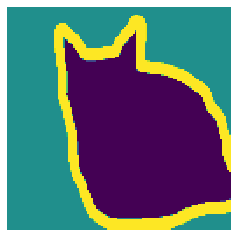

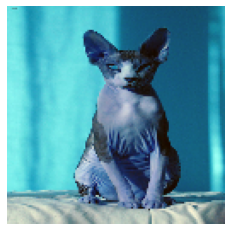

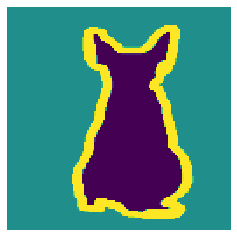

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from tensorflow.keras.applications.resnet import ResNet50, preprocess_input

dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

IMG_SHAPE  = 128
BATCH_SIZE = 32

# Method that will process the images and masks of the dataset.
def load_image(datapoint):
  
  input_image = tf.image.resize(datapoint['image'], (IMG_SHAPE, IMG_SHAPE))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SHAPE, IMG_SHAPE))
  input_image = preprocessing_function=preprocess_input(input_image)
  input_mask -= 1

  return input_image, input_mask

# We process each datapoint with the created method.
train_images = dataset['train'].map(load_image).batch(BATCH_SIZE)
test_images  = dataset['test'].map(load_image).batch(BATCH_SIZE)

# We display the loaded images.
for images, masks in train_images.take(1):
  for i in range(5):
    plt.imshow(tf.keras.utils.array_to_img(images[i]))
    plt.axis('off')
    plt.show()
    plt.matshow(tf.keras.utils.array_to_img(masks[i]))
    plt.axis('off')
    plt.show()

In [ ]:
from tensorflow.keras import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *

from tensorflow.keras.callbacks import EarlyStopping

pretrained_RN50 = ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_SHAPE,IMG_SHAPE,3))

for layer in pretrained_RN50.layers[:12]:
  layer.trainable = False

z = 10

#Encoder
pretrainet_inp = pretrained_RN50.input
pretrained_out = pretrained_RN50.output
encode = Flatten()(pretrained_out)
dense_enc = Dense(z)(encode)

#Decoder
input_decoder = Input(shape = z)

dense_dec = Dense(16384)(input_decoder)
convert_tensor = Reshape((16,16,64))(dense_dec)

dec_1 = Conv2DTranspose(filters=32, kernel_size=5, strides=2, padding="same", activation="relu")(convert_tensor)
dec_2 = Conv2DTranspose(filters=16, kernel_size=5, strides=2, padding="same", activation="relu")(dec_1)
dec_3 = Conv2DTranspose(filters=3,  kernel_size=5, strides=2, padding="same", activation="softmax")(dec_2)


# We create separate models.
model_enc = Model(inputs = pretrainet_inp, outputs = dense_enc)
model_dec = Model(inputs = input_decoder, outputs = dec_3)

# We join both models to create the autoencoder.
autoenc_head = model_enc(pretrainet_inp)
autoenc_main = model_dec(autoenc_head)

autoencoder = Model(inputs=pretrainet_inp, outputs=autoenc_main)


early_stop = EarlyStopping(monitor="val_acc", patience=5)

autoencoder.compile(Adam(), loss=SparseCategoricalCrossentropy(), metrics=["acc"])
autoencoder.fit(train_images, validation_data=test_images, epochs=20, callbacks=[early_stop])

Epoch 1/20
115/115 [==============================] - 72s 320ms/step - loss: 0.6955 - acc: 0.6887 - val_loss: 0.8664 - val_acc: 0.6705
Epoch 2/20
115/115 [==============================] - 28s 245ms/step - loss: 0.4990 - acc: 0.7977 - val_loss: 0.7794 - val_acc: 0.7336
Epoch 3/20
115/115 [==============================] - 28s 246ms/step - loss: 0.4346 - acc: 0.8191 - val_loss: 0.5322 - val_acc: 0.7946
Epoch 4/20
115/115 [==============================] - 29s 251ms/step - loss: 0.3941 - acc: 0.8325 - val_loss: 0.4637 - val_acc: 0.8130
Epoch 5/20
115/115 [==============================] - 36s 317ms/step - loss: 0.3784 - acc: 0.8386 - val_loss: 0.4584 - val_acc: 0.8165
Epoch 6/20
115/115 [==============================] - 29s 248ms/step - loss: 0.3593 - acc: 0.8449 - val_loss: 0.4258 - val_acc: 0.8273
Epoch 7/20
115/115 [==============================] - 36s 314ms/step - loss: 0.3423 - acc: 0.8511 - val_loss: 0.4399 - val_acc: 0.8238
Epoch 8/20
115/115 [==============================] - 3